### Notebook solution test technique 
### Amine MEKKI

### Importing necessary libraries

In this notebook, I will be implementing a solution to detect phishing URLs. The notebook is structured as follows:

- Data Analysis and Feature Engineering: This section involves initial data analysis and the creation of various features to help in phishing URL detection. Some of the features might take a considerable amount of time to compute.

- Processed Data: To save time, I recommend skipping to the part where the processed data is loaded after importing the necessary libraries. This allows you to bypass the time-consuming feature engineering steps and directly proceed with model training and evaluation.
- [Go to processed data](#Lets-load-the-processed-data)

In [1]:
import re
import math
from typing import Dict, Tuple
import pandas as pd
import seaborn as sns
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import dns.resolver
from collections import Counter

from pyspark.sql import SparkSession
from pyspark.sql.functions import length, col, regexp_replace, monotonically_increasing_id, udf, col, expr
from pyspark.ml.feature import Tokenizer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType, StringType, StructType, StructField
from pyspark.ml.stat import Correlation
from imblearn.over_sampling import SMOTE
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.sql import DataFrame


In [2]:

spark = SparkSession.builder \
    .appName('PhishingURLDetection') \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.storage.memoryFraction", "0.6") \
    .getOrCreate()


24/07/15 20:40:24 WARN Utils: Your hostname, AmineLaptop resolves to a loopback address: 127.0.1.1; using 10.188.27.252 instead (on interface wlo1)
24/07/15 20:40:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/15 20:40:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:

file_path = './artifacts/data/raw/urls_dataset.csv'
df_spark = spark.read.csv(file_path, sep="\t",header=True, inferSchema=True)



# I. EDA

## I.1 Data Overview

In [ ]:
df_spark.printSchema()
df_spark.show(5)

In [ ]:

df_spark = df_spark.withColumn('label', col('label').cast('integer'))


In [ ]:

df_spark = df_spark.drop('_c0')

In [ ]:
df_spark.show(5)

## I.2 checking for missing Values

In [ ]:
df_spark.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()


No missing values so that is good.

### I.3 Class distribution

In [ ]:
class_distribution = df_spark.groupBy('label').count()
class_distribution.show()

In [ ]:
df_spark = df_spark.filter((col('label') == 0) | (col('label') == 1))
class_distribution = df_spark.groupBy('label').count()
class_distribution.show()

In [ ]:

class_distribution = df_spark.groupBy('label').count().toPandas()
plt.bar(class_distribution['label'], class_distribution['count'])
plt.show()



We can see that we have 65% of non phishing urls 
and 35% of phishing urls  

In the following case i wanted to investigate the prefix, i saw that sometimes there are different prefixes

In [ ]:
# create a copy of the original dataframe
df_spark_copy = df_spark

def extract_prefix(url):
    if url.startswith("http"):
        return "http"
    elif url.startswith("https"):
        return "https"
    elif url.startswith("jvvru"):
        return "jvvru"
    elif url.startswith("jvvr"):
        return "jvvr"
    else:
        return "other"

extract_prefix_udf = udf(extract_prefix, StringType())
df_spark_copy = df_spark_copy.withColumn("prefix", extract_prefix_udf(col("url")))
df_spark_copy.show()
contingency_table = df_spark_copy.groupBy("prefix").pivot("label").count().na.fill(0)
contingency_table.show()
df_grouped = df_spark_copy.groupBy("prefix").agg(
    expr("sum(label)").alias("phishing_count"),
    expr("count(*)").alias("total_count"),
    expr("sum(label) / count(*) * 100").alias("phishing_percentage")
)
df_grouped.show()

# II. Feature Engineering

Since our urls are textual data. Let's try to use these textual data to extract some numerical data.
The following features have been selected after carefully looking into the dataset.

In [ ]:
sensitive_words = ['secure', 'account', 'webscr', 'login', 'ebayisapi', 'signin']

def subdomain_level(url : str) -> int:
    """
    Calculate the subdomain level of the URL
    
    Args:
        url (str): The URL
    
    Returns:
        int: The subdomain level
    """
    try:
        hostname = urlparse(url).hostname
        if hostname:
            return len(hostname.split('.')) - 2
        return 0
    except Exception as e:
        print(f"Error in subdomain_level: {e}")
        return 0

def path_level(url : str) -> int:
    """
    Calculate the path level of the URL
    
    Args:
        url (str): The URL
    
    Returns:
        int: The path level
    """
    try:
        path = urlparse(url).path
        return len(path.split('/')) - 1
    except Exception as e:
        print(f"Error in path_level: {e}")
        return 0

def count_dashes_hostname(url : str) -> int:
    """
    Count the number of dashes in the hostname of the URL.
    
    Args:
        url (str): The URL
    
    Returns:
        int: The number of dashes in the hostname
    """
    try:
        hostname = urlparse(url).hostname
        if hostname:
            return hostname.count('-')
        return 0
    except Exception as e:
        print(f"Error in count_dashes_hostname: {e}")
        return 0

def no_https(url : str) -> int:
    """
    Check if the URL does not have HTTPS
    
    Args:
        url (str): The URL
    
    Returns:
        int: 1 if the URL does not have HTTPS, 0 otherwise
    """
    try:
        return 0 if urlparse(url).scheme == 'https' else 1
    except Exception as e:
        print(f"Error in no_https: {e}")
        return 0

def random_string(url : str) -> int:
    """
    Check if the URL has a random string of characters
    
    Args:
        url (str): The URL
    
    Returns:
        int: 1 if the URL has a random string of characters, 0 otherwise
    """
    try:
        return 1 if re.search(r'[a-zA-Z]{10,}', url) else 0
    except Exception as e:
        print(f"Error in random_string: {e}")
        return 0

def ip_address(url : str) -> int:
    """
    Check if the URL has an IP address
    
    Args:
        url (str): The URL
    
    Returns:
        int: 1 if the URL has an IP address, 0 otherwise
    """
    try:
        return 1 if re.match(r'^(http|https):\/\/\d+\.\d+\.\d+\.\d+', url) else 0
    except Exception as e:
        print(f"Error in ip_address: {e}")
        return 0

def domain_in_subdomains(url : str) -> int:
    """
    Check if the domain is in the subdomains of the URL
    
    Args:
        url (str): The URL
    
    Returns:
        int: 1 if the domain is in the subdomains, 0 otherwise
    """
    try:
        hostname = urlparse(url).hostname
        if hostname:
            domain_parts = hostname.split('.')
            return 1 if len(domain_parts) > 2 else 0
        return 0
    except Exception as e:
        print(f"Error in domain_in_subdomains: {e}")
        return 0

def domain_in_paths(url : str) -> int:
    """
    Check if the domain is in the paths of the URL
    
    Args:
        url (str): The URL
    
    Returns:
        int: 1 if the domain is in the paths, 0 otherwise
    """
    try:
        path = urlparse(url).path
        hostname = urlparse(url).hostname
        if hostname and path:
            return 1 if hostname in path else 0
        return 0
    except Exception as e:
        print(f"Error in domain_in_paths: {e}")
        return 0

def https_in_hostname(url : str) -> int:
    """
    Check if the URL has HTTPS in the hostname
    
    Args:
        url (str): The URL
    
    Returns:
        int: 1 if the URL has HTTPS in the hostname, 0 otherwise
    """
    try:
        hostname = urlparse(url).hostname
        return 1 if hostname and 'https' in hostname else 0
    except Exception as e:
        print(f"Error in https_in_hostname: {e}")
        return 0

def hostname_length(url : str) -> int:
    """
    Calculate the length of the hostname of the URL
    
    Args:
        url (str): The URL
    
    Returns:
        int: The length of the hostname
    """
    try:
        hostname = urlparse(url).hostname
        return len(hostname) if hostname else 0
    except Exception as e:
        print(f"Error in hostname_length: {e}")
        return 0


def count_sensitive_words(url : str) -> int:
    """
    Count the number of sensitive words in the URL
    
    Args:
        url (str): The URL
    
    Returns:
        int: The number of sensitive words in the URL
    """
    try:
        return sum(word in url.lower() for word in sensitive_words)
    except Exception as e:
        print(f"Error in count_sensitive_words: {e}")
        return 0


def count_www(url : str) -> int:
    """
    Count the number of 'www' in the URL
    
    Args:
        url (str): The URL
    
    Returns:
        int: The number of 'www' in the URL
    """
    try:
        return url.count('www')
    except Exception as e:
        print(f"Error in count_www: {e}")
        return 0

def fd_length(url : str) -> int:
    """
    Calculate the length of the first directory of the URL
    
    Args:
        url (str): The URL
    
    Returns:
        int: The length of the first directory
    """
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0
    
def has_prefix_jvvr(url : str) -> int:
    """
    Check if the URL has the prefix 'jvvr'
    
    Args:
        url (str): The URL
    
    Returns:
        int: 1 if the URL has the prefix 'jvvr', 0 otherwise
    """
    try:
        return 1 if url.startswith("jvvr") else 0
    except Exception as e:
        print(f"Error in has_prefix_jvvr: {e}")
        return 0
    

def has_prefix_jvvru(url : str) -> int:
    try:
        return 1 if url.startswith("jvvru") else 0
    except Exception as e:
        print(f"Error in has_prefix_jvvru: {e}")
        return 0

def calculate_entropy(url : str) -> float:
    """
    Calculate the entropy of the URL
    
    Args:
        url (str): The URL
    
    Returns:
        float: The entropy of the URL
    """
    try:
        counter = Counter(url)
        total_len = len(url)
        entropy = -sum((count / total_len) * math.log2(count / total_len) for count in counter.values())
        return entropy
    except Exception as e:
        print(f"Error in calculate_entropy: {e}")
        return 0



In [ ]:
# Here i am defining the user defined functions for the above feature funnctions

subdomain_level_udf = udf(subdomain_level, IntegerType())
path_level_udf = udf(path_level, IntegerType())
count_dashes_hostname_udf = udf(count_dashes_hostname, IntegerType())
no_https_udf = udf(no_https, IntegerType())
random_string_udf = udf(random_string, IntegerType())
ip_address_udf = udf(ip_address, IntegerType())
domain_in_subdomains_udf = udf(domain_in_subdomains, IntegerType())
sensitive_words = ['secure', 'account', 'webscr', 'login', 'ebayisapi', 'signin']
domain_in_paths_udf = udf(domain_in_paths, IntegerType())
hostname_length_udf = udf(hostname_length, IntegerType())
https_in_hostname_udf = udf(https_in_hostname, IntegerType())
count_sensitive_words_udf = udf(count_sensitive_words, IntegerType())
count_www_udf = udf(count_www, IntegerType())
fd_length_udf = udf(fd_length, IntegerType())
has_prefix_jvvr_udf = udf(has_prefix_jvvr, IntegerType())
has_prefix_jvvru_udf = udf(has_prefix_jvvru, IntegerType())
entropy_udf = udf(calculate_entropy, FloatType())


In [ ]:
# here i am applying the above udfs ..
df_spark = df_spark.withColumn('url_length', length(col('url')))
df_spark = df_spark.withColumn('num_dots', length(regexp_replace(col('url'), '[^.]', '')) - 1)
df_spark = df_spark.withColumn('num_hyphens', length(regexp_replace(col('url'), '[^-]', '')) - 1)
df_spark = df_spark.withColumn('num_digits', length(regexp_replace(col('url'), '[^\d]', '')))
df_spark = df_spark.withColumn('num_alpha', length(regexp_replace(col('url'), '[^a-zA-Z]', '')))
df_spark = df_spark.withColumn('subdomain_level', subdomain_level_udf('url'))
df_spark = df_spark.withColumn('path_level', path_level_udf('url'))
df_spark = df_spark.withColumn('count_dashes_hostname', count_dashes_hostname_udf('url'))
df_spark = df_spark.withColumn('no_https', no_https_udf('url'))
df_spark = df_spark.withColumn('random_string', random_string_udf('url'))
df_spark = df_spark.withColumn('ip_address', ip_address_udf('url'))
df_spark = df_spark.withColumn('domain_in_subdomains', domain_in_subdomains_udf('url'))
df_spark = df_spark.withColumn('domain_in_paths', domain_in_paths_udf('url'))
df_spark = df_spark.withColumn('https_in_hostname', https_in_hostname_udf('url'))
df_spark = df_spark.withColumn('hostname_length', hostname_length_udf('url'))
df_spark = df_spark.withColumn('count_sensitive_words', count_sensitive_words_udf('url'))
df_spark = df_spark.withColumn('count_www', count_www_udf('url'))
df_spark = df_spark.withColumn('fd_length', fd_length_udf(col('url')))
df_spark = df_spark.withColumn("has_prefix_jvvr", has_prefix_jvvr_udf(col("url")))
df_spark = df_spark.withColumn("has_prefix_jvvru", has_prefix_jvvru_udf(col("url")))
df_spark = df_spark.withColumn('url_entropy', entropy_udf(col('url')))


In [ ]:
df_spark.show(5, truncate=False)

### Checking for special characters

I think also the amount of special characters can be an indicator or a url that is classified as phishing.

In [ ]:
features = ['@','?','-','=','.','#','%','+','$','!','*',',','//', '&']

for a in features:
    df_spark = df_spark.withColumn('num_'+a, length(regexp_replace(col('url'), '[^'+a+']', '')))

df_spark = df_spark.withColumnRenamed('num_.', 'num_dot')
df_spark = df_spark.withColumnRenamed('num_#', 'num_hash')
df_spark = df_spark.withColumnRenamed('num_%', 'num_percent')
df_spark = df_spark.withColumnRenamed('num_+', 'num_plus')
df_spark = df_spark.withColumnRenamed('num_$', 'num_dollar')
df_spark = df_spark.withColumnRenamed('num_!', 'num_exclamation')
df_spark = df_spark.withColumnRenamed('num_*', 'num_asterisk')
df_spark = df_spark.withColumnRenamed('num_,', 'num_comma')
df_spark = df_spark.withColumnRenamed('num_&', 'num_query_symbol')

### More Advanced features DNS Takes too much time. that's why i saved them 
After doing some research about URLs i found that the following DNS features can be helpful to detect if a url phishing. This helped to gain 10% in most metrics that i have used.

These features they provide insights into the website's configuration and behavior patterns. Legitimate websites generally have well configured DNS settings with multiple A records for load balancing and fault tolerance, while phishing websites may not invest in such robust configurations, leading to fewer DNS records. 

So by analyzing DNS resolution patterns can reveal some anomalies typical of phishing sites, which they often use newly registered domains with minimal DNS history. Additionally, Using IP address analysis we can identify less reputable IP ranges associated with phishing sites, and features like the sum of IP octets can highlight these irregularities. 

Lastly, the URL structure and length can also indicate phishing attempts, as legitimate domains are typically concise and recognizable, whereas phishing domains may be excessively long or contain unusual subdomains to mislead users.

In [ ]:

def ensure_scheme(url : str) -> str:
    """
    Ensure that the URL has a scheme (http or https)
    
    Args:
        url (str): The URL
    
    Returns:
        str: The URL with a scheme
    """
    try:
        if not urlparse(url).scheme:
            return 'http://' + url
        return url
    except Exception as e:
        print(f"Error in ensure_scheme: {e}")
        return url


def get_dns_info(url : str) -> tuple:
    """
    Get DNS information for the URL
    
    Args:
        url (str): The URL
    
    Returns:
        tuple: A tuple containing the number of DNS answers, the number of IP octets, the sum of the IP octets, 
        whether the URL has an IP address, and the length of the domain
    """
    try:
        url = ensure_scheme(url)
        domain = urlparse(url).hostname
        print(f"fetched domain: {domain}")
        if not domain:
            return (0, 0, 0, 0, 0)

        answers = dns.resolver.resolve(domain, 'A')
        ip_address = answers[0].address if answers else None
        return (len(answers), len(ip_address.split('.')), sum(int(x) for x in ip_address.split('.')), 1 if ip_address else 0, len(domain))
    except Exception as e:
        print(f"Error retrieving DNS data for {url}: {e}")
        return (0, 0, 0, 0, 0)  # default values

schema = StructType([
    StructField("num_dns_answers", IntegerType(), True),
    StructField("num_ip_octets", IntegerType(), True),
    StructField("sum_ip_octets", IntegerType(), True),
    StructField("has_ip_address", IntegerType(), True),
    StructField("domain_length", IntegerType(), True)
])

In [ ]:
get_dns_info_udf = udf(get_dns_info, schema)

df_spark = df_spark.withColumn('dns_info', get_dns_info_udf('url'))

df_spark = df_spark.cache()
df_spark.count()

for field in schema.fields:
    df_spark = df_spark.withColumn(field.name, df_spark['dns_info'][field.name])

df_spark = df_spark.drop('dns_info')


#### Save processed Data

In [ ]:
# df_spark.write.mode('overwrite').parquet('./artifacts/data/old_processed/urls_dataset.parquet')

# Lets load the processed data

In [3]:

df_spark = spark.read.parquet('./artifacts/data/old_processed/urls_dataset.parquet')

### Data analysis of the built features


In [4]:
all_columns = df_spark.columns

numeric_columns = [c for c, t in df_spark.dtypes if t in ['double', 'float']]
non_numeric_columns = [c for c, t in df_spark.dtypes if t not in ['double', 'float']]

null_exprs = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in all_columns]

nan_exprs = [F.count(F.when(F.isnan(c), c)).alias(c) for c in numeric_columns]

exprs = null_exprs + nan_exprs

df_spark.select(exprs).show()


24/07/15 20:40:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-----+----------+--------+-----------+----------+---------+---------------+----------+---------------------+--------+-------------+----------+--------------------+---------------+-----------------+---------------+---------------------+---------+---------+---------------+----------------+-----------+-----+-----+-----+-----+-------+--------+-----------+--------+----------+---------------+------------+---------+------+----------------+---------------+-------------+-------------+--------------+-------------+-----------+
|url|label|url_length|num_dots|num_hyphens|num_digits|num_alpha|subdomain_level|path_level|count_dashes_hostname|no_https|random_string|ip_address|domain_in_subdomains|domain_in_paths|https_in_hostname|hostname_length|count_sensitive_words|count_www|fd_length|has_prefix_jvvr|has_prefix_jvvru|url_entropy|num_@|num_?|num_-|num_=|num_dot|num_hash|num_percent|num_plus|num_dollar|num_exclamation|num_asterisk|num_comma|num_//|num_query_symbol|num_dns_answers|num_ip_octets|su

As we can see we have no null values

#### Correlation

24/07/15 20:40:37 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


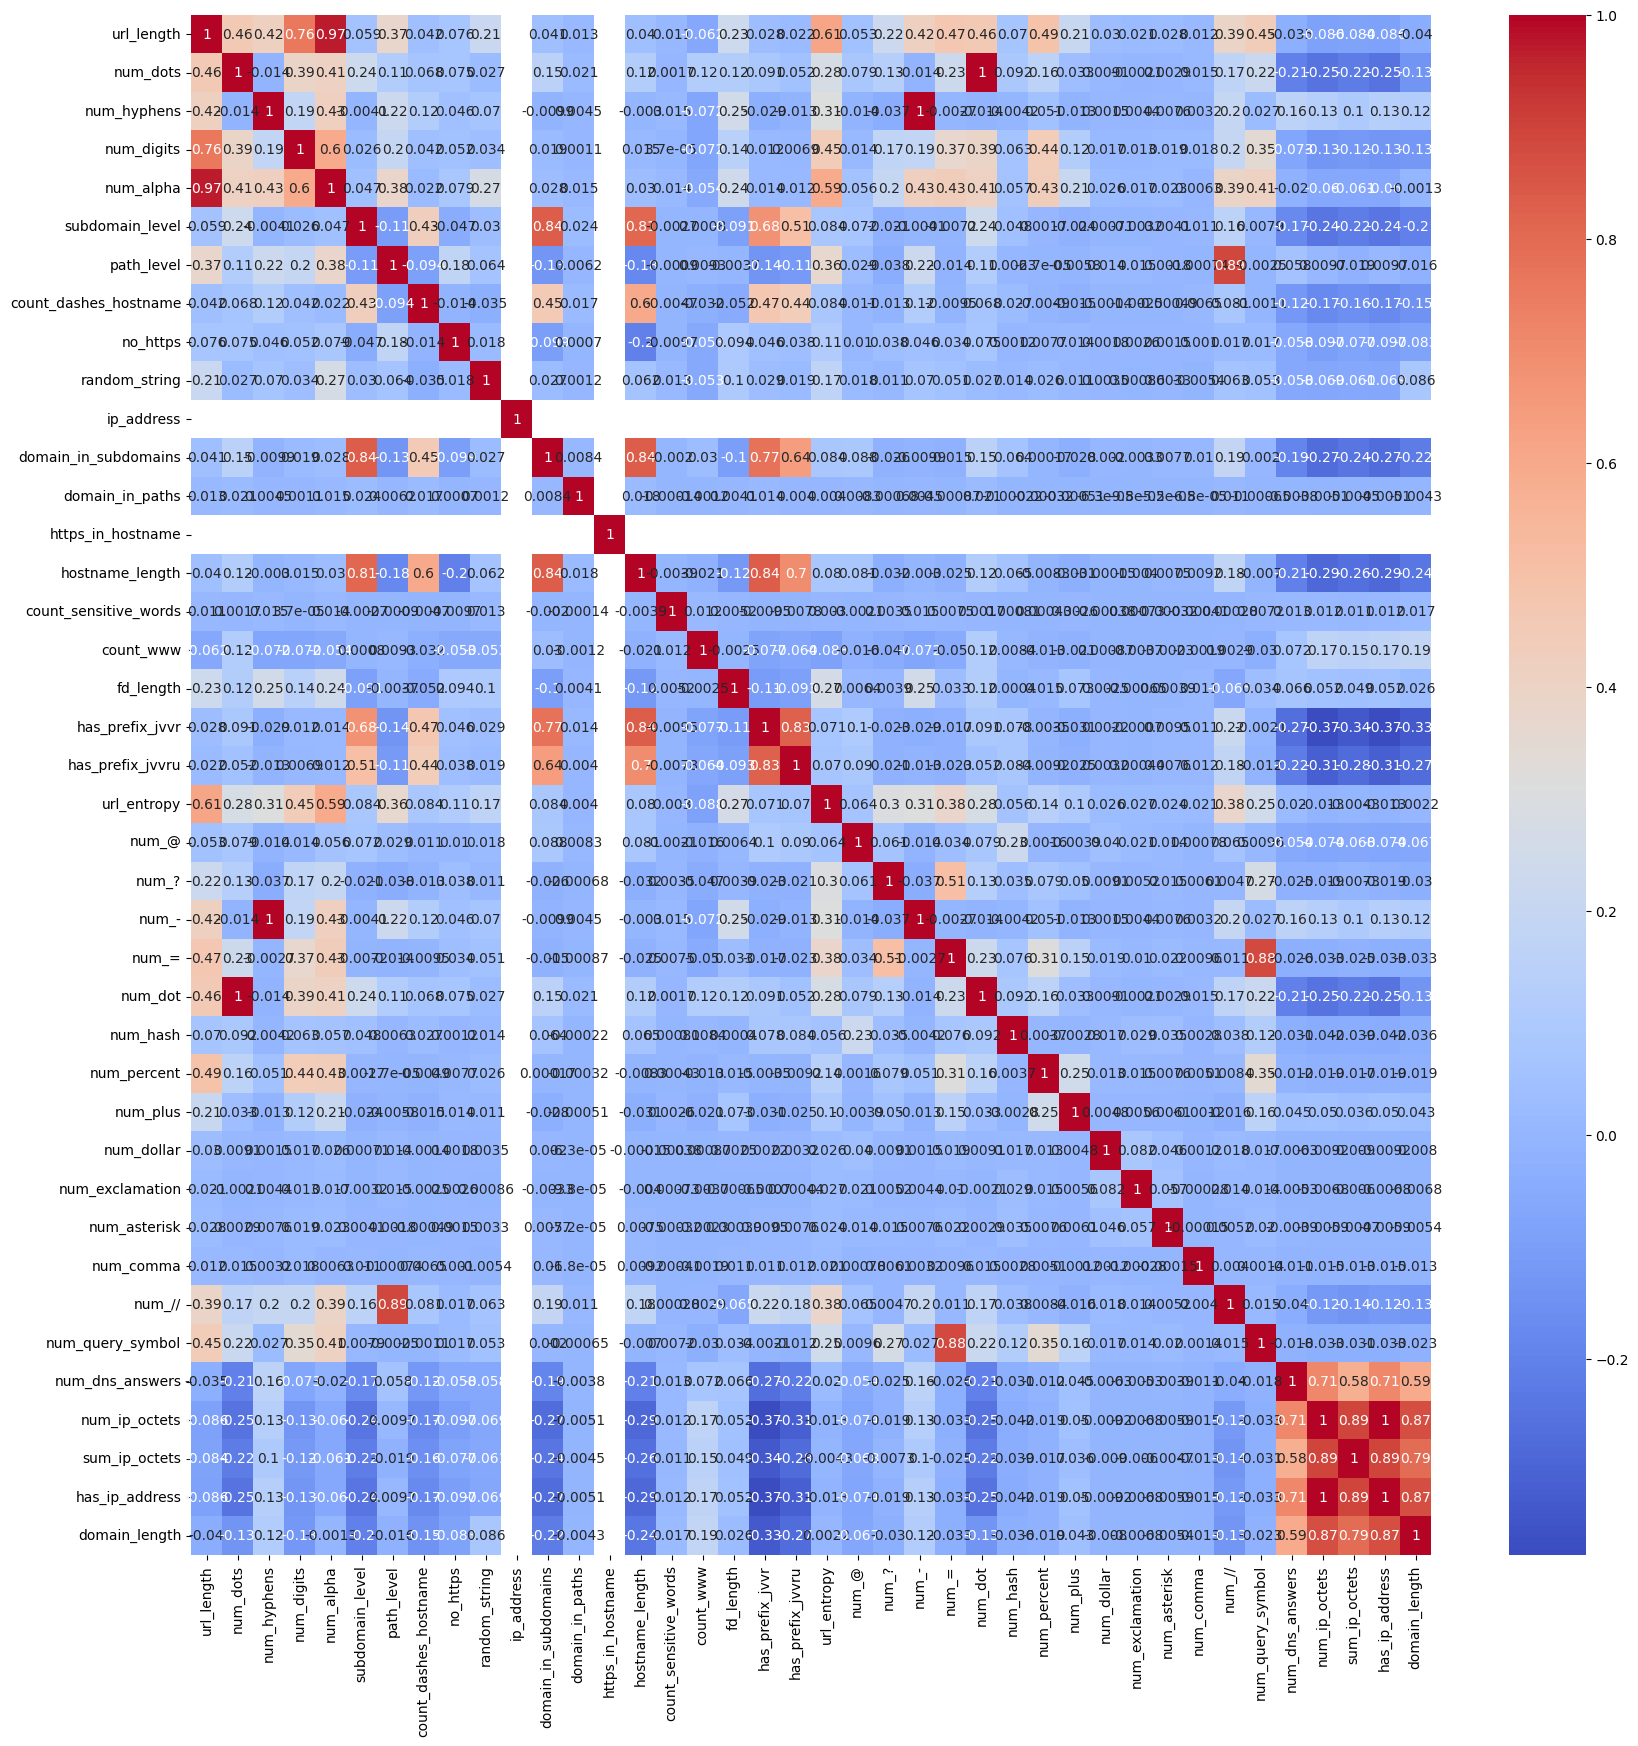

In [5]:
# let's analyze the correlation between the features 
features = ['url_length', 'num_dots', 'num_hyphens', 'num_digits', 'num_alpha', 'subdomain_level', 'path_level', 'count_dashes_hostname', 'no_https', 'random_string', 'ip_address', 'domain_in_subdomains', 'domain_in_paths', 'https_in_hostname', 'hostname_length', 'count_sensitive_words', 'count_www', 'fd_length', 'has_prefix_jvvr', 'has_prefix_jvvru', 'url_entropy', 'num_@', 'num_?', 'num_-', 'num_=', 'num_dot', 'num_hash', 'num_percent', 'num_plus', 'num_dollar',
    'num_exclamation', 'num_asterisk', 'num_comma', 'num_//', 'num_query_symbol', 'num_dns_answers', 'num_ip_octets', 'sum_ip_octets', 'has_ip_address', 'domain_length']


assembler = VectorAssembler(inputCols=features, outputCol='features')
df_spark = assembler.transform(df_spark)

correlation_matrix = Correlation.corr(df_spark, 'features').collect()[0][0]
correlation_matrix_arr = correlation_matrix.toArray()



df = pd.DataFrame(correlation_matrix_arr, columns=features, index=features)
plt.figure(figsize=(20, 20))
sns.heatmap(df, annot=True, cmap='coolwarm')
plt.show()


24/07/15 20:40:39 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


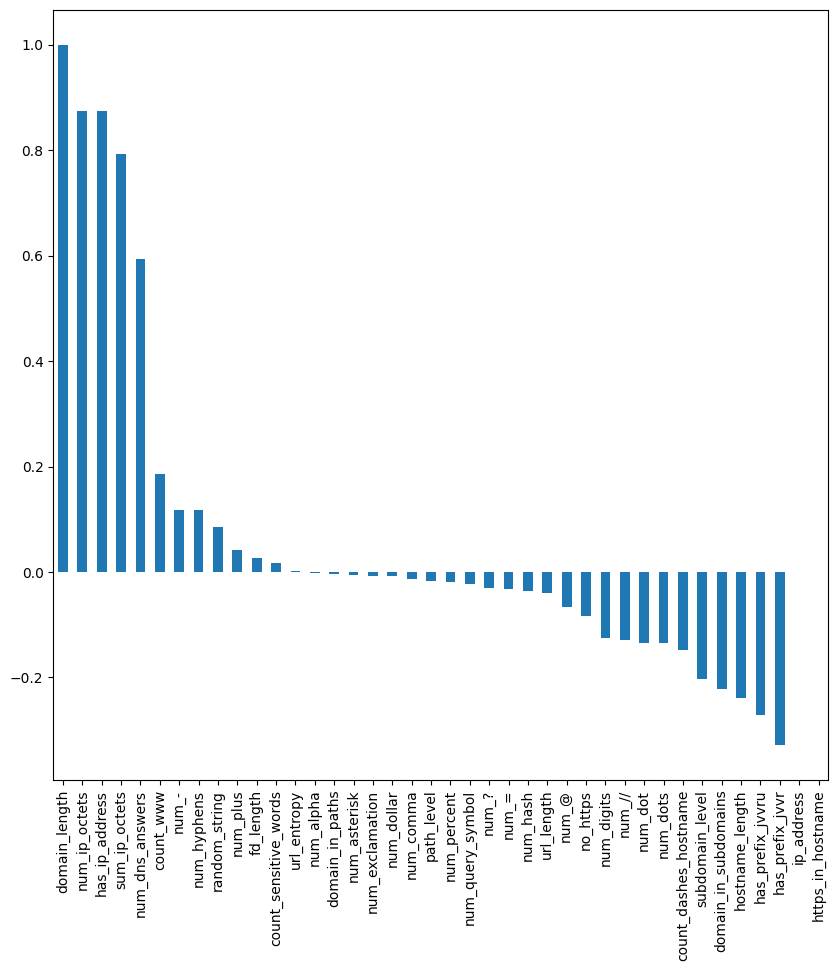

In [6]:
correlation_with_label = Correlation.corr(df_spark, 'features', 'pearson').head()[0].toArray()[-1]
correlation_with_label = pd.Series(correlation_with_label, index=features)
correlation_with_label = correlation_with_label.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
correlation_with_label.plot(kind='bar')
plt.show()


As we can the dns feature are highly correlated with the target class

### Class distribution and resampling

#### class distribution
here i am investigating distribution of our target classes to understand the imbalance.

In [7]:
df_spark = df_spark.filter((col('label') == 0) | (col('label') == 1))
class_distribution = df_spark.groupBy('label').count()
class_distribution.show()

+-----+------+
|label| count|
+-----+------+
|    1|219681|
|    0|407332|
+-----+------+



In [8]:
df_class_0 = df_spark.filter(df_spark.label == 0)
df_class_1 = df_spark.filter(df_spark.label == 1)
ratio = int(df_class_0.count() / df_class_1.count())


In [9]:

total_count = df_spark.count()
class_0_count = df_class_0.count()
class_1_count = df_class_1.count()

class_0_weight = total_count / (2 * class_0_count)
class_1_weight = total_count / (2 * class_1_count)

df_spark = df_spark.withColumn("class_weight", F.when(df_spark.label == 0, class_0_weight).otherwise(class_1_weight))


In [10]:
print(f"Class 0 weight: {class_0_weight}")
print(f"Class 1 weight: {class_1_weight}")

Class 0 weight: 0.7696584113204953
Class 1 weight: 1.427098838770763


#### downsampling
We reduce the number of instances in the majority class to balance the dataset.

In [ ]:
# y_resampled

In [ ]:
# df_balanced_down = df_balanced_down.filter((col('label') == 0) | (col('label') == 1))
# class_distribution = df_balanced_down.groupBy('label').count()
# class_distribution.show()

In [18]:
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)


In [19]:
# create copy of train_data and test_data
train_data_over = train_data


#### overssampling
Here i am using SMOTE, the Synthetic Minority Over-sampling Technique to generate synthetic instances for the minority class to balance the dataset.

In [25]:
# drop column features from train_data and test_data
train_data_over = train_data_over.drop('features')
train_data_over = train_data_over.drop('class_weight')
train_data_over = train_data_over.drop('url')


In [28]:
train_data_pandas = train_data_over.toPandas()

X = train_data_pandas.drop('label', axis=1)
y = train_data_pandas['label']

smote = SMOTE(random_state=42)
X_over_sampled, y_over_sampled = smote.fit_resample(X, y)
train_data_over_sampled_pandas = pd.concat([X_over_sampled, y_over_sampled], axis=1)
train_data_over_sampled_spark = spark.createDataFrame(train_data_over_sampled_pandas)

## Machine Learning

In this part, i'll train and evaluate different machine learning models to detect phishing URLs. 

I am three models: 
- Random Forest, 
- Gradient Boosting
- Logistic Regression. 
    
Each model is evaluated using accuracy, precision, recall, F1 score, and AUC (Area Under the ROC Curve).


#### Stacking : Meta-Classifier:
I am using stacking approach where predictions from Random Forest, Logistic Regression, and Gradient Boosting are used as features to train a meta-classifier (Logistic Regression).

In [42]:
def train_and_evaluate_models(
    train_data: DataFrame, 
    test_data: DataFrame, 
    feature_cols: str, 
    use_class_weights: bool = False
) -> Tuple[Dict[str, Dict[str, float]], Dict[str, RandomForestClassifier]]:
    """
    Train and evaluate machine learning models.

    Args:
        train_data (DataFrame): Training data.
        test_data (DataFrame): Testing data.
        feature_cols (str): Name of the feature column.
        use_class_weights (bool): Whether to use class weights.

    Returns:
        Tuple[Dict[str, Dict[str, float]], Dict[str, RandomForestClassifier]]: Evaluation results and trained models.
    """
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction')
    
    if use_class_weights:
        models = {
            'RandomForest': RandomForestClassifier(featuresCol=feature_cols, labelCol='label', weightCol='class_weight'),
            'GBT': GBTClassifier(featuresCol=feature_cols, labelCol='label', weightCol='class_weight'),
            'LogisticRegression': LogisticRegression(featuresCol=feature_cols, labelCol='label', weightCol='class_weight')
        }
    else:
        models = {
            'RandomForest': RandomForestClassifier(featuresCol=feature_cols, labelCol='label'),
            'GBT': GBTClassifier(featuresCol=feature_cols, labelCol='label'),
            'LogisticRegression': LogisticRegression(featuresCol=feature_cols, labelCol='label')
        }
    
    trained_models = {}
    
    for model_name, model in models.items():
        trained_models[model_name] = model.fit(train_data)
    
    def evaluate_model(model, test_data, evaluator):
        predictions = model.transform(test_data)
        auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
        accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(test_data.count())
        tp = predictions.filter((predictions.label == 1) & (predictions.prediction == 1)).count()
        fp = predictions.filter((predictions.label == 0) & (predictions.prediction == 1)).count()
        fn = predictions.filter((predictions.label == 1) & (predictions.prediction == 0)).count()
        
        precision = tp / float(tp + fp) if (tp + fp) != 0 else 0.0
        recall = tp / float(tp + fn) if (tp + fn) != 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0.0
        
        return accuracy, precision, recall, f1, auc

    results = {}
    
    for model_name, model in trained_models.items():
        accuracy, precision, recall, f1, auc = evaluate_model(model, test_data, evaluator)
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'AUC': auc
        }
    
    return results, trained_models

#### Results with All features with only class weights

In [43]:
results_normal, trained_models_normal = train_and_evaluate_models(train_data, test_data, 'features', use_class_weights=True)


In [44]:
for model_name, metrics in results_normal.items():
    print(f'{model_name} - Accuracy: {metrics["Accuracy"]}, Precision: {metrics["Precision"]}, Recall: {metrics["Recall"]}, F1: {metrics["F1"]}, AUC: {metrics["AUC"]}')


RandomForest - Accuracy: 0.9316601607714475, Precision: 0.8374283919837086, Recall: 0.9995683780099954, F1: 0.9113428538881352, AUC: 0.9824115517403957
GBT - Accuracy: 0.9450551204987587, Precision: 0.8685908251781567, Recall: 0.9940254429804635, F1: 0.927084547178406, AUC: 0.9880807060251833
LogisticRegression - Accuracy: 0.937391734719129, Precision: 0.8508174783266422, Recall: 0.996569741026806, F1: 0.9179439428338269, AUC: 0.9825660537356629


#### Results with Over Sampling

In [45]:
assembler = VectorAssembler(inputCols=features, outputCol='features')
train_data_over_sampled_spark = assembler.transform(train_data_over_sampled_spark)


IllegalArgumentException: Output column features already exists.

In [46]:
results_resampled_over, trained_models_resampled_over = train_and_evaluate_models(train_data_over_sampled_spark, test_data, "features", False)


24/07/15 21:05:14 WARN TaskSetManager: Stage 2543 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:05:15 WARN TaskSetManager: Stage 2546 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:05:15 WARN TaskSetManager: Stage 2547 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:05:16 WARN TaskSetManager: Stage 2548 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:05:16 WARN TaskSetManager: Stage 2550 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:05:18 WARN TaskSetManager: Stage 2552 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:05:18 WARN TaskSetManager: Stage 2554 contains a task of very large size (3691 KiB). The maximum recommended task size is 10

In [47]:
for model_name, metrics in results_resampled_over.items():
    print(f'{model_name} - Accuracy: {metrics["Accuracy"]}, Precision: {metrics["Precision"]}, Recall: {metrics["Recall"]}, F1: {metrics["F1"]}, AUC: {metrics["AUC"]}')


RandomForest - Accuracy: 0.932650014767983, Precision: 0.8393834767182343, Recall: 0.9996138119036801, F1: 0.9125182750432899, AUC: 0.9827401762212821
GBT - Accuracy: 0.9490305018719416, Precision: 0.8829443008608234, Recall: 0.985620172648796, F1: 0.9314612651488317, AUC: 0.9879790176950731
LogisticRegression - Accuracy: 0.9373677866385676, Precision: 0.8509994178148651, Recall: 0.9961835529304861, F1: 0.9178859236002093, AUC: 0.9822954950134026


## Meta Mpdel Training and results

In [48]:

def train_and_evaluate_stacking_model(
    train_data: DataFrame, 
    test_data: DataFrame, 
    rf_model: RandomForestClassifier, 
    lr_model: LogisticRegression, 
    gbt_model: GBTClassifier, 
    feature_cols: str,
    use_class_weights=False
) -> Tuple[Dict[str, float], LogisticRegression]:
    """
    Train and evaluate a stacking meta-classifier.

    Args:
        train_data (DataFrame): Training data.
        test_data (DataFrame): Testing data.
        rf_model (RandomForestClassifier): Pre-trained Random Forest model.
        lr_model (LogisticRegression): Pre-trained Logistic Regression model.
        gbt_model (GBTClassifier): Pre-trained Gradient Boosting Trees model.
        feature_cols (str): Name of the feature column.

    Returns:
        Tuple[Dict[str, float], LogisticRegression]: Evaluation results and the trained meta-classifier.
    """
    train_data = train_data.withColumn("unique_id", monotonically_increasing_id())
    test_data = test_data.withColumn("unique_id", monotonically_increasing_id())

    train_rf_predictions = rf_model.transform(train_data).select('unique_id', col('prediction').alias('rf_prediction'))
    train_lr_predictions = lr_model.transform(train_data).select('unique_id', col('prediction').alias('lr_prediction'))
    train_gb_predictions = gbt_model.transform(train_data).select('unique_id', col('prediction').alias('gb_prediction'))

    meta_train_data = train_data.join(train_rf_predictions, 'unique_id').join(train_lr_predictions, 'unique_id').join(train_gb_predictions, 'unique_id')

    feature_cols = ['rf_prediction', 'lr_prediction', 'gb_prediction'] + [feature_cols]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='meta_features')
    meta_train_data = assembler.transform(meta_train_data)

    if use_class_weights:
        meta_lr = LogisticRegression(labelCol='label', featuresCol='meta_features', weightCol='class_weight')
    else:
        meta_lr = LogisticRegression(labelCol='label', featuresCol='meta_features')
    
    meta_lr_model = meta_lr.fit(meta_train_data)

    test_rf_predictions = rf_model.transform(test_data).select('unique_id', col('prediction').alias('rf_prediction'))
    test_lr_predictions = lr_model.transform(test_data).select('unique_id', col('prediction').alias('lr_prediction'))
    test_gb_predictions = gbt_model.transform(test_data).select('unique_id', col('prediction').alias('gb_prediction'))

    meta_test_data = test_data.join(test_rf_predictions, 'unique_id').join(test_lr_predictions, 'unique_id').join(test_gb_predictions, 'unique_id')

    meta_test_data = assembler.transform(meta_test_data)

    predictions = meta_lr_model.transform(meta_test_data)

    predictions = predictions.withColumn('prediction_label', expr('prediction'))
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
    meta_auc = evaluator.evaluate(predictions)
    correct_predictions = predictions.filter(predictions['label'] == predictions['prediction_label']).count()
    total_predictions = predictions.count()
    meta_accuracy = correct_predictions / total_predictions

    tp = predictions.filter((predictions['label'] == 1) & (predictions['prediction_label'] == 1)).count()
    fp = predictions.filter((predictions['label'] == 0) & (predictions['prediction_label'] == 1)).count()
    fn = predictions.filter((predictions['label'] == 1) & (predictions['prediction_label'] == 0)).count()

    meta_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    meta_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    meta_f1 = 2 * meta_precision * meta_recall / (meta_precision + meta_recall) if (meta_precision + meta_recall) > 0 else 0
    # calculate the
    print(f'Meta-Classifier - Accuracy: {meta_accuracy}, Precision: {meta_precision}, Recall: {meta_recall}, F1: {meta_f1}')

    return {
        'Accuracy': meta_accuracy,
        'Precision': meta_precision,
        'Recall': meta_recall,
        'F1': meta_f1,
        'AUC': meta_auc
    }, meta_lr_model

#### Results with All features with class weights

In [49]:
results_meta_normal, meta_lr_model_normal = train_and_evaluate_stacking_model(train_data, test_data, trained_models_normal["RandomForest"], trained_models_normal["LogisticRegression"], trained_models_normal["GBT"], "features", use_class_weights=True)

print(results_meta_normal)


Meta-Classifier - Accuracy: 0.9452147743691677, Precision: 0.8692731211862217, Recall: 0.9935029532030895, F1: 0.9272455502432922
{'Accuracy': 0.9452147743691677, 'Precision': 0.8692731211862217, 'Recall': 0.9935029532030895, 'F1': 0.9272455502432922, 'AUC': 0.9831575437472269}


#### Results with Over Sampling

In [50]:
results_resampled_over, meta_lr_model_resampled_over = train_and_evaluate_stacking_model(train_data_over_sampled_spark, test_data, trained_models_resampled_over["RandomForest"], trained_models_resampled_over["LogisticRegression"], trained_models_resampled_over["GBT"], "features")

print(results_resampled_over)


24/07/15 21:06:28 WARN TaskSetManager: Stage 3314 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:06:31 WARN TaskSetManager: Stage 3315 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:06:32 WARN TaskSetManager: Stage 3316 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:06:33 WARN TaskSetManager: Stage 3317 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:06:35 WARN TaskSetManager: Stage 3318 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:06:35 WARN TaskSetManager: Stage 3319 contains a task of very large size (3691 KiB). The maximum recommended task size is 1000 KiB.
24/07/15 21:06:36 WARN TaskSetManager: Stage 3320 contains a task of very large size (3691 KiB). The maximum recommended task size is 10

Meta-Classifier - Accuracy: 0.9492220865164324, Precision: 0.8836569612257789, Recall: 0.9852112676056338, F1: 0.9316748837259261
{'Accuracy': 0.9492220865164324, 'Precision': 0.8836569612257789, 'Recall': 0.9852112676056338, 'F1': 0.9316748837259261, 'AUC': 0.9833031852637011}


The above results shows that Gradient Boosting and the Meta-Classifier consistently performed the best across different sampling methods. The use of class weights, over-sampling, and under-sampling techniques significantly improved the models' performance, particularly in recall and AUC scores.

In [51]:
# Get Feature importance
rf_model = trained_models_normal["RandomForest"]
feature_importance = rf_model.featureImportances
feature_importance = [(features[i], feature_importance[i]) for i in range(len(features))]
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance:
    print(f'{feature}: {importance}')
    

num_ip_octets: 0.2839043334507168
has_ip_address: 0.24200954245245102
sum_ip_octets: 0.19764203802058605
domain_length: 0.13906484159955124
num_dns_answers: 0.10299063012111176
has_prefix_jvvr: 0.012057266555611722
count_www: 0.008242745007920464
num_dots: 0.0036714383389483086
num_hyphens: 0.003496054284534645
num_-: 0.0014465472851289418
hostname_length: 0.001403717541998036
num_digits: 0.001115993706290154
has_prefix_jvvru: 0.0007654379969147063
num_plus: 0.00043429477400050675
fd_length: 0.0003663270728758021
url_entropy: 0.0003488933118984346
num_dot: 0.00034477316724280634
num_//: 0.0001722153362494268
path_level: 0.00013949166327125275
subdomain_level: 0.00011995154213422063
num_alpha: 0.00011237344623027542
url_length: 9.736834586767645e-05
num_=: 2.5267810637519662e-05
num_?: 1.2624578073731647e-05
num_percent: 5.171417382497996e-06
num_asterisk: 3.8067193127081586e-06
num_hash: 3.639082164982377e-06
num_@: 2.066876648040511e-06
count_dashes_hostname: 5.273448324585842e-07
cou

The feature importance analysis from the Random Forest model reveals that DNS related features are the most significant in predicting phishing URLs. Specifically, num_ip_octets, domain_length, has_ip_address, and num_dns_answers are the top contributors, with importance scores of 0.296, 0.256, 0.199, and 0.136, respectively.